## Simple Lyot Coronagraph
Optics without the apodizer. Sanity check

In [1]:
%%capture
## ignore warnings...

## autoreload scripts
%load_ext autoreload
%autoreload 2

from __future__ import division
exec(open('../prep.py'))
exec(open('../codes/func.py'))
exec(open('../codes/util.py'))
% matplotlib inline

### Incident light

### Masks
#### read in...

In [215]:
primary_path  = '../../masks/gemini_primary.fits'

## K band - 2.19 um ; use K1
#apod_k_path = '../../masks/gpi_k1_apodizer.fits'
lyot_k_path = '../../masks/gpi_k1_lyot.fits'
fpm_k_path = '../../masks/gpi_k1_fpm.fits'

## H band - 1.65 um
apod_h_path = '../../masks/gpi_h_apodizer.fits'
lyot_h_path = '../../masks/gpi_h_lyot.fits'
fpm_h_path = '../../masks/gpi_h_fpm.fits'

In [218]:
pri_d_, pri_h  = read_fits(primary_path)

#apo_k_d, apo_k_h  = read_fits(apod_k_path)
fpm_k_d_, fpm_k_h  = read_fits(fpm_k_path)
lyo_k_d_, lyo_k_h  = read_fits(lyot_k_path)

apo_h_d_, apo_h_h  = read_fits(apod_h_path)
fpm_h_d_, fpm_h_h  = read_fits(fpm_h_path)
lyo_h_d_, lyo_h_h  = read_fits(lyot_h_path)

#### K band (k1)

Original I intended to scale the sampling frequency according to the given pixelsize in the mask files, but the required value turned out to be prohibitive (7302 for K band...). So now the masks are reduced twice in size. (I do not want to force FFT to compute in 2^n grid since matching pixel sizes would only introduce more artifacts.

In [140]:
pri_d = pri_d_[::4,::4]
fpm_k_d = fpm_k_d_[::2,::2]
lyo_k_d = lyo_k_d_[::4,::4]

pNaxis, fNaxis, lNaxis = pri_h['NAXIS1']/4, fpm_k_h['NAXIS1']/2, lyo_k_h['NAXIS1']/4
p_pixs, f_pixs, l_pixs = pri_h['pixscale']*4, fpm_k_h['pixscale']*2, lyo_k_h['pixscale']*4

Apodizer    size = 256.0 pixels; pixel scale = 0.03125 (m)
Coronagraph size = 512.0 pixels; pixel scale = 0.0052734375 (arcsec)
Lyot mask   size = 256.0 pixels; pixel scale = 0.03125 (m)


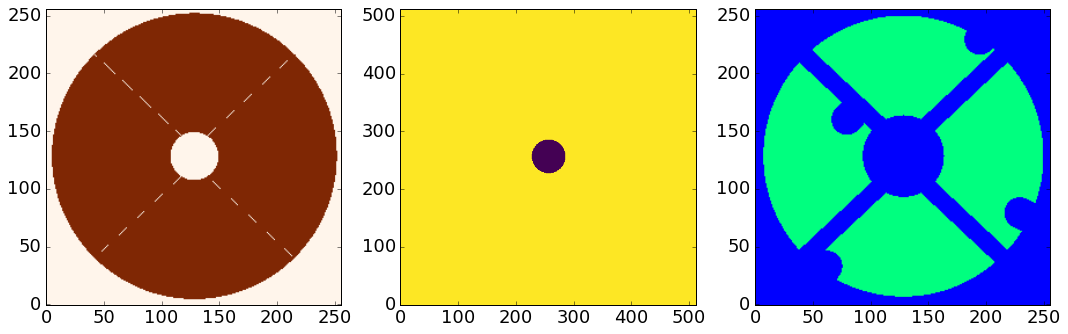

In [152]:
plt.figure(figsize=(18,36))
plt.subplot(131); plt.imshow(pri_d,origin='lower',cmap=plt.get_cmap('Oranges'))
plt.subplot(132); plt.imshow(fpm_k_d,origin='lower',cmap=plt.get_cmap('viridis'))
plt.subplot(133); plt.imshow(lyo_k_d,origin='lower',cmap=plt.get_cmap('winter'))
print 'Apodizer    size = %s pixels; pixel scale = %s (m)' %(pNaxis,p_pixs)
print 'Coronagraph size = %s pixels; pixel scale = %s (arcsec)' %(fNaxis,f_pixs)
print 'Lyot mask   size = %s pixels; pixel scale = %s (m)' %(lNaxis,l_pixs)

#### How big is the 'primary'?
This determines the 'sampling frequency' as defined in the `sim_opt` [notebook](https://github.com/Mipanox/GPI_stuff/blob/master/sim_opt.ipynb). 

In [143]:
# parameters
## pixel scales
#-- conform to masks
k_pix_arc = f_pixs * u.arcsec
p_pix_met = p_pixs * u.m

## extension of the primary mask
allowedx = np.where(pri_d==1)[0]
D_tel = (allowedx.max()-allowedx.min())*p_pix_met
lba_k = 2.19 * u.um

## sampling frequency
f_s = ((lba_k/D_tel/k_pix_arc).to(u.rad**-1)).value

## required number of pixels
N_pix = int((allowedx.max()-allowedx.min()) * f_s) + 1
print N_pix

2742


In [144]:
## centroid
ctx,cty = (N_pix-1)/2, (N_pix-1)/2

##
kx_min,kx_max = ((0-ctx)*k_pix_arc).value,((N_pix-ctx)*k_pix_arc).value
ky_min,ky_max = ((0-cty)*k_pix_arc).value,((N_pix-cty)*k_pix_arc).value
klin = np.linspace(kx_min,kx_max,N_pix)

px_min,px_max = ((0-ctx)*p_pix_met).value,((N_pix-ctx)*p_pix_met).value
py_min,py_max = ((0-cty)*p_pix_met).value,((N_pix-cty)*p_pix_met).value
plin = np.linspace(px_min,px_max,N_pix)

## Inputs

In [154]:
pri_p = pad_array(pri_d,N_pix)
#apo_k_p = pad_array(apo_k_d,N_pix)
fpm_k_p = pad_array(fpm_k_d,N_pix)
lyo_k_p = pad_array(lyo_k_d,N_pix)

### Star light

In [146]:
One = np.ones((N_pix,N_pix))
Zer = np.zeros((N_pix,N_pix))

In [147]:
Str_amp = One * pri_p
Str_pha = Zer * pri_p * u.rad

Str_inc_ef = Str_amp*np.exp(1j*Str_pha.value)

---
## Optics

(-0.1, 1.1)

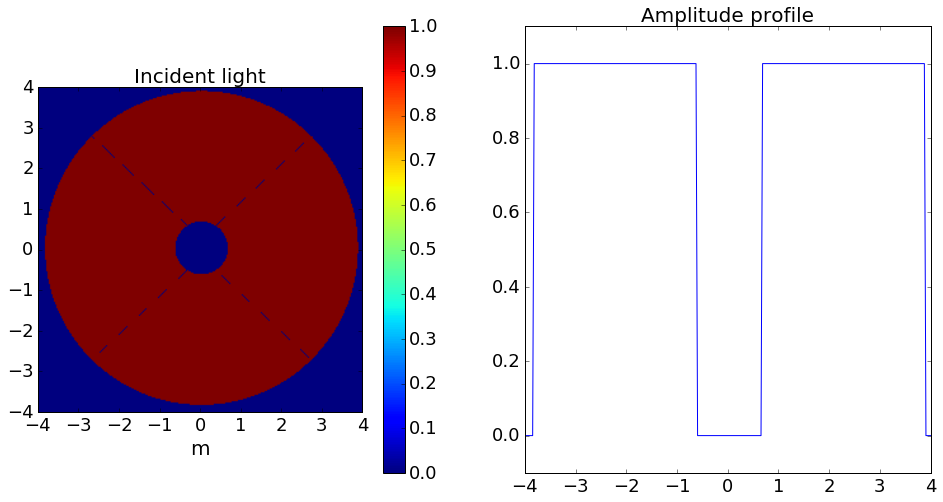

In [148]:
plt.figure(figsize=(16,8))
plt.subplot(121); plt.imshow(abs(Str_inc_ef)**2,origin='lower',
                            extent=(px_min,px_max,py_min,py_max))
plt.title('Incident light'); plt.xlabel('m')
plt.colorbar(); plt.xlim(-4,4); plt.ylim(-4,4)

plt.subplot(122); plt.plot(plin,abs(Str_inc_ef)[int(N_pix/2),:])
plt.title('Amplitude profile'); plt.xlim(-4,4); plt.ylim(-0.1,1.1)

### First focal plane

In [149]:
%time
Str_ffoc_ef = Ef_aft_from_Ef(Str_inc_ef)

CPU times: user 4 µs, sys: 1 µs, total: 5 µs
Wall time: 11.9 µs


(-2, 2)

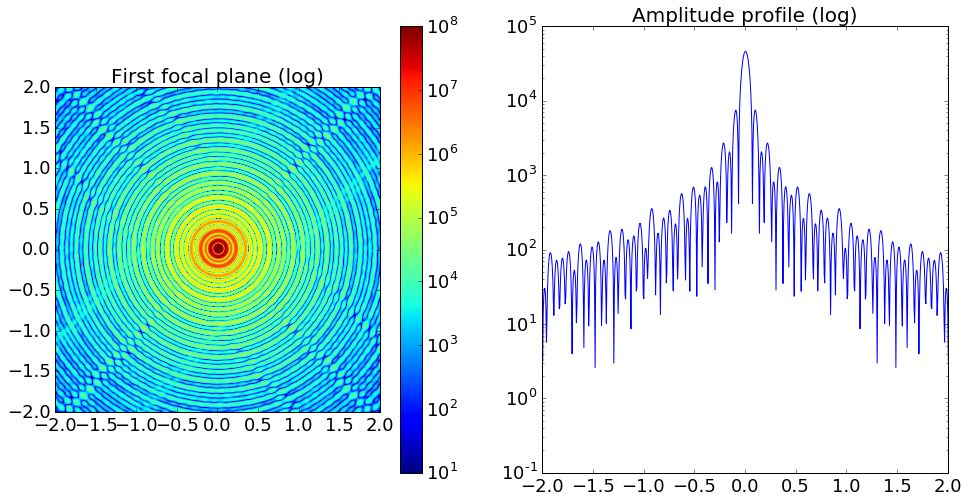

In [150]:
plt.figure(figsize=(16,8))
plt.subplot(121); plt.imshow(abs(Str_ffoc_ef)**2,origin='lower',
                             extent=(kx_min,kx_max,ky_min,ky_max),norm=LogNorm())
plt.xlim(-2,2); plt.ylim(-2,2); plt.title('First focal plane (log)')
plt.colorbar(); plt.clim(10,1e8)

plt.subplot(122); plt.plot(klin,abs(Str_ffoc_ef)[int(N_pix/2),:])
plt.yscale('log'); plt.title('Amplitude profile (log)')
plt.xlim(-2,2)

Let's ignore the new artifacts caused by the resizing of the masks.

### Coronagraph

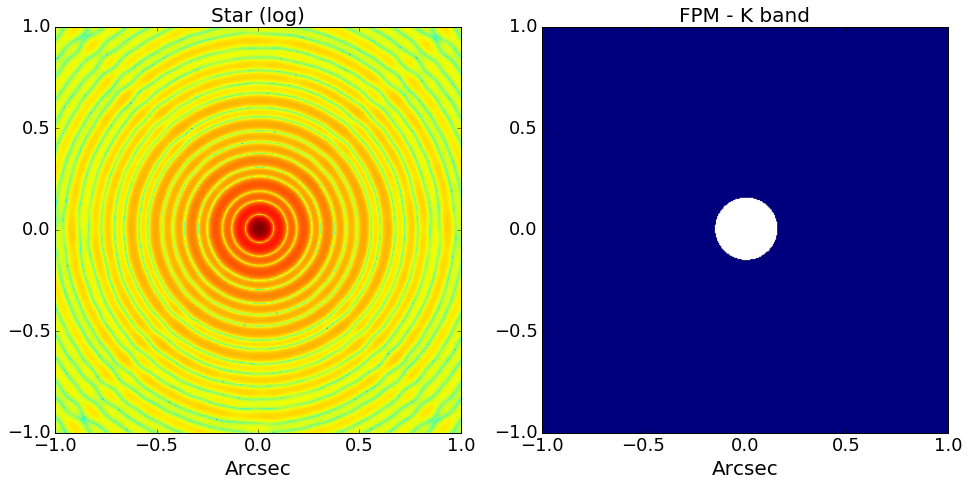

In [155]:
plt.figure(figsize=(16,8))
plt.subplot(121); plt.imshow(abs(Str_ffoc_ef)**2,origin='lower', \
                             extent=(kx_min,kx_max,ky_min,ky_max),norm=LogNorm())
plt.xlim(-1,1); plt.ylim(-1,1); plt.title('Star (log)')
plt.xlabel('Arcsec')

plt.subplot(122); plt.imshow(fpm_k_p,origin='lower', \
                             extent=(kx_min,kx_max,ky_min,ky_max),norm=LogNorm())
plt.xlim(-1,1); plt.ylim(-1,1); plt.title('FPM - K band')
plt.xlabel('Arcsec')

#### Masking

In [156]:
Str_coro_ef = Str_ffoc_ef * fpm_k_p

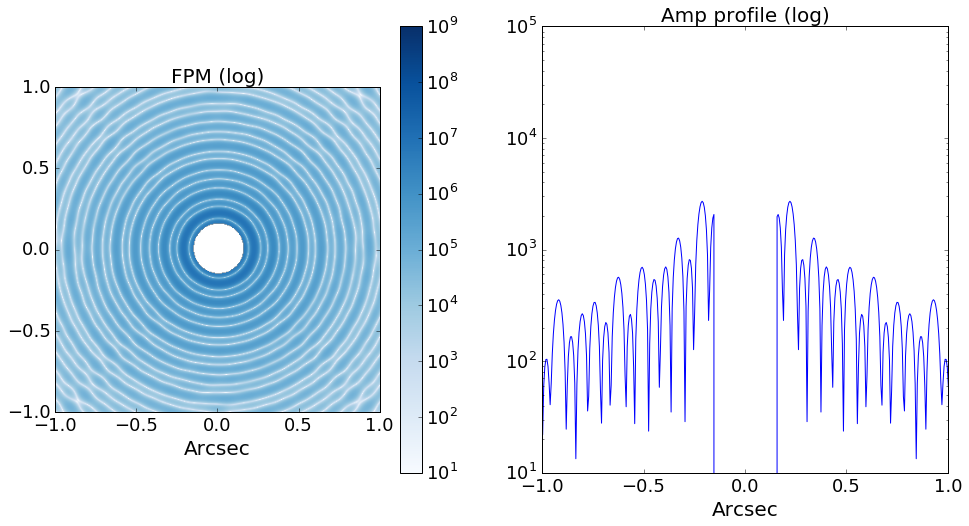

In [157]:
plt.figure(figsize=(16,8))
plt.subplot(121); plt.imshow(abs(Str_coro_ef)**2,origin='lower', \
                             extent=(kx_min,kx_max,ky_min,ky_max),norm=LogNorm(), \
                             cmap='Blues')
plt.xlim(-1,1); plt.ylim(-1,1); plt.title('FPM (log)')
plt.xlabel('Arcsec'); plt.colorbar(); plt.clim(10,1e9)

plt.subplot(122); plt.plot(klin,abs(Str_coro_ef)[int(N_pix/2),:])
plt.xlim(-1,1); plt.ylim(10,1e5); plt.title('Amp profile (log)')
plt.xlabel('Arcsec'); plt.yscale('log')

Pretty and symmetric!

### Second pupil plane - Lyot
#### Transform back

In [158]:
%time
Str_2pup_ef = Ef_ift_from_Ef(Str_coro_ef)

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 8.82 µs


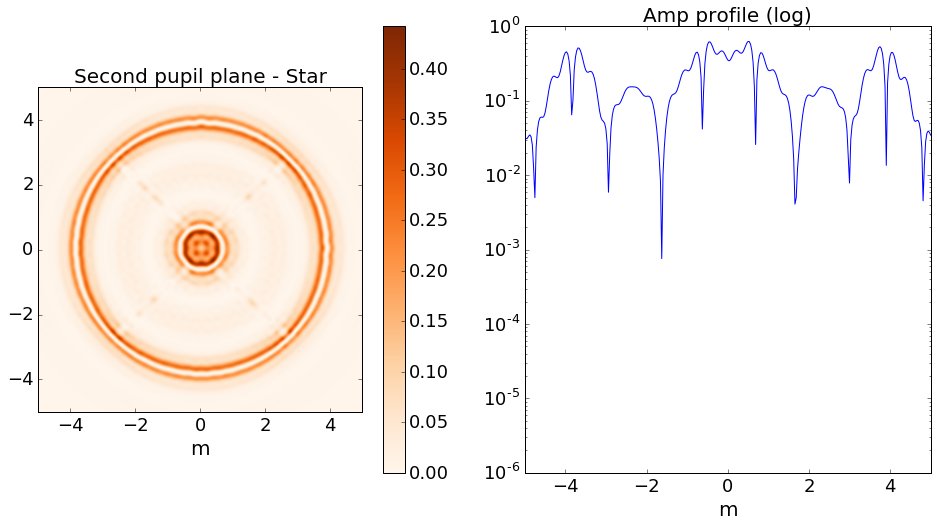

In [164]:
plt.figure(figsize=(16,8))
plt.subplot(121); plt.imshow(abs(Str_2pup_ef)**2,origin='lower',
                             extent=(px_min,px_max,py_min,py_max),cmap='Oranges')#,norm=LogNorm())
plt.title('Second pupil plane - Star'); #plt.clim(0,0.15)
plt.xlim(-5,5); plt.ylim(-5,5); plt.colorbar(); plt.xlabel('m')

plt.subplot(122); plt.plot(plin,abs(Str_2pup_ef)[int(N_pix/2),:])
plt.xlim(-5,5); plt.title('Amp profile (log)'); plt.yscale('log'); plt.xlabel('m')

Interesting, what are the troughs?

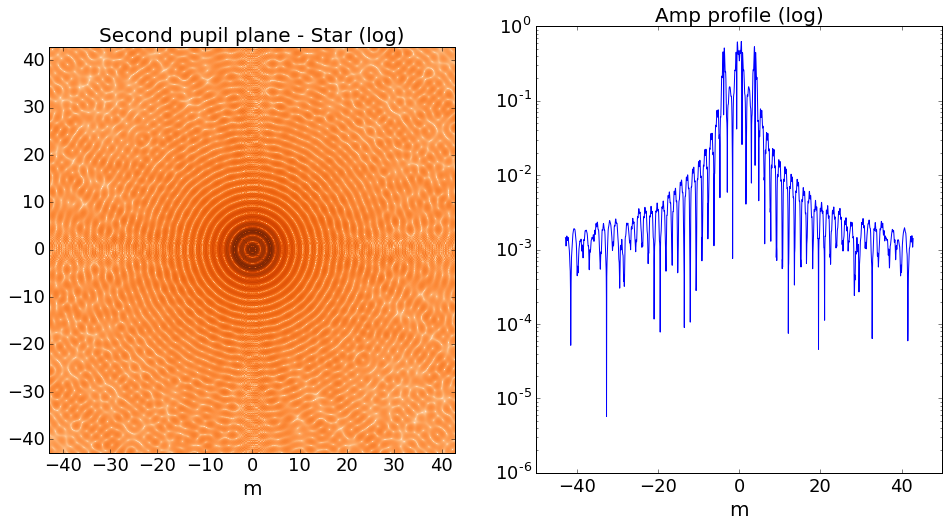

In [165]:
plt.figure(figsize=(16,8))
plt.subplot(121); plt.imshow(abs(Str_2pup_ef)**2,origin='lower',
                             extent=(px_min,px_max,py_min,py_max),cmap='Oranges',norm=LogNorm())
plt.title('Second pupil plane - Star (log)'); plt.clim(1e-10,0.15); plt.xlabel('m')

plt.subplot(122); plt.plot(plin,abs(Str_2pup_ef)[int(N_pix/2),:])
plt.title('Amp profile (log)'); plt.yscale('log'); plt.xlabel('m')

The "outer ring" is clearly seen, irrelevant to whether there's troughs or not.

#### Lyot

In [166]:
Str_lyo_ef = Str_2pup_ef * lyo_k_p

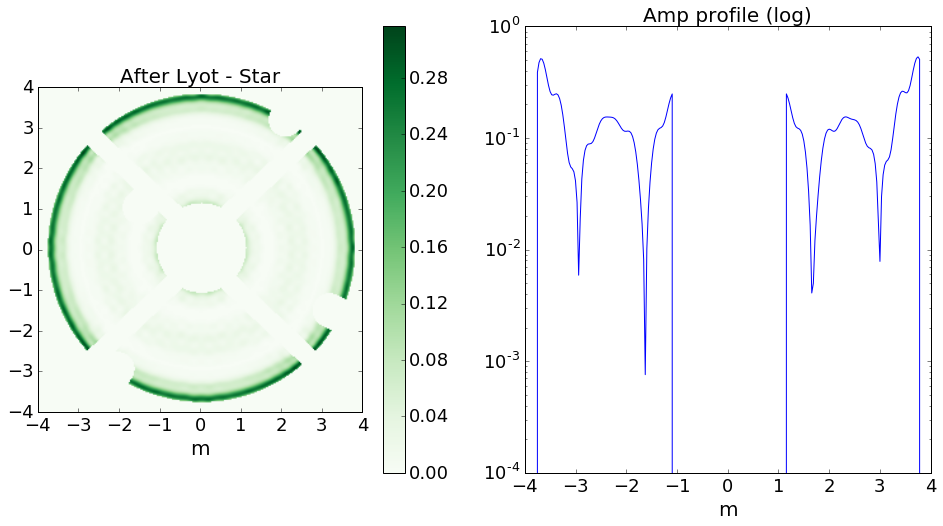

In [170]:
plt.figure(figsize=(16,8))
plt.subplot(121); plt.imshow(abs(Str_lyo_ef)**2,origin='lower',
                             extent=(px_min,px_max,py_min,py_max),cmap='Greens')
plt.xlim(-4,4); plt.ylim(-4,4); plt.title('After Lyot - Star')
plt.colorbar();  plt.xlabel('m')

plt.subplot(122); plt.plot(plin,abs(Str_lyo_ef)[int(N_pix/2),:])
plt.xlim(-4,4); plt.title('Amp profile (log)')
plt.yscale('log'); plt.xlabel('m')

Lyot stop not blocking the whole ring? Hmmm... Perhaps it has to do with the wavelength. I shall try another one below, just showing the final few steps

### Final image

In [171]:
%time
Str_final_ef = Ef_aft_from_Ef(Str_lyo_ef)

CPU times: user 2 µs, sys: 1e+03 ns, total: 3 µs
Wall time: 5.01 µs


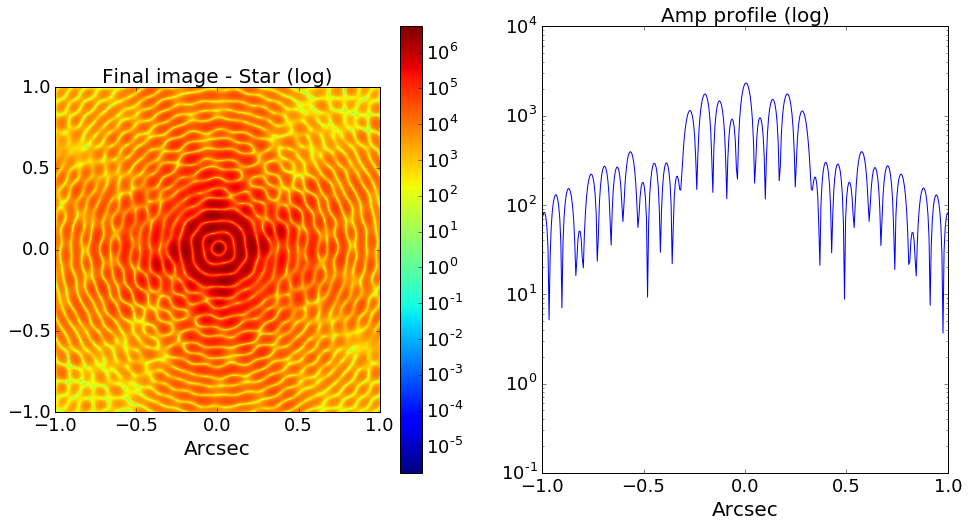

In [172]:
plt.figure(figsize=(16,8))
plt.subplot(121); plt.imshow(abs(Str_final_ef)**2,origin='lower', \
                             extent=(kx_min,kx_max,ky_min,ky_max),norm=LogNorm())
plt.xlim(-1,1); plt.ylim(-1,1); plt.title('Final image - Star (log)')
plt.xlabel('Arcsec'); plt.colorbar()

plt.subplot(122); plt.plot(klin,abs(Str_final_ef)[int(N_pix/2),:])
plt.xlim(-1,1); plt.title('Amp profile (log)')
plt.xlabel('Arcsec'); plt.yscale('log')

---
## Different wavelength - Lyot stop test
All the pixel matching and numerical stuff should be correct by far. Here is for H band

In [204]:
pri_d = pri_d_[::4,::4]
fpm_h_d = fpm_k_d_[::2,::2]
lyo_h_d = lyo_k_d_[::4,::4]

pNaxis, fNaxis, lNaxis = pri_h['NAXIS1']/4, fpm_h_h['NAXIS1']/2, lyo_h_h['NAXIS1']/4
p_pixs, f_pixs, l_pixs = pri_h['pixscale']*4, fpm_h_h['pixscale']*2, lyo_h_h['pixscale']*4

In [205]:
k_pix_arc = f_pixs * u.arcsec
p_pix_met = p_pixs * u.m

allowedx = np.where(pri_d==1)[0]
D_tel = (allowedx.max()-allowedx.min())*p_pix_met

lba_k = 1.65 * u.um
f_s = ((lba_k/D_tel/k_pix_arc).to(u.rad**-1)).value
N_pix = int((allowedx.max()-allowedx.min()) * f_s) + 1
print N_pix

2066


In [206]:
## centroid
ctx,cty = (N_pix-1)/2, (N_pix-1)/2

##
kx_min,kx_max = ((0-ctx)*k_pix_arc).value,((N_pix-ctx)*k_pix_arc).value
ky_min,ky_max = ((0-cty)*k_pix_arc).value,((N_pix-cty)*k_pix_arc).value
klin = np.linspace(kx_min,kx_max,N_pix)

px_min,px_max = ((0-ctx)*p_pix_met).value,((N_pix-ctx)*p_pix_met).value
py_min,py_max = ((0-cty)*p_pix_met).value,((N_pix-cty)*p_pix_met).value
plin = np.linspace(px_min,px_max,N_pix)

In [212]:
pri_p = pad_array(pri_d,N_pix)
fpm_h_p = pad_array(fpm_k_d,N_pix)
lyo_h_p = pad_array(lyo_k_d,N_pix)

One = np.ones((N_pix,N_pix))
Zer = np.zeros((N_pix,N_pix))

Str_amp = One * pri_p
Str_pha = Zer * pri_p * u.rad

##
Str_inc_ef = Str_amp*np.exp(1j*Str_pha.value)

In [208]:
%time
Str_ffoc_ef = Ef_aft_from_Ef(Str_inc_ef)

In [209]:
Str_coro_ef = Str_ffoc_ef * fpm_h_p

In [210]:
%time
Str_2pup_ef = Ef_ift_from_Ef(Str_coro_ef)

CPU times: user 3 µs, sys: 1e+03 ns, total: 4 µs
Wall time: 7.87 µs


In [213]:
Str_lyo_ef = Str_2pup_ef * lyo_h_p

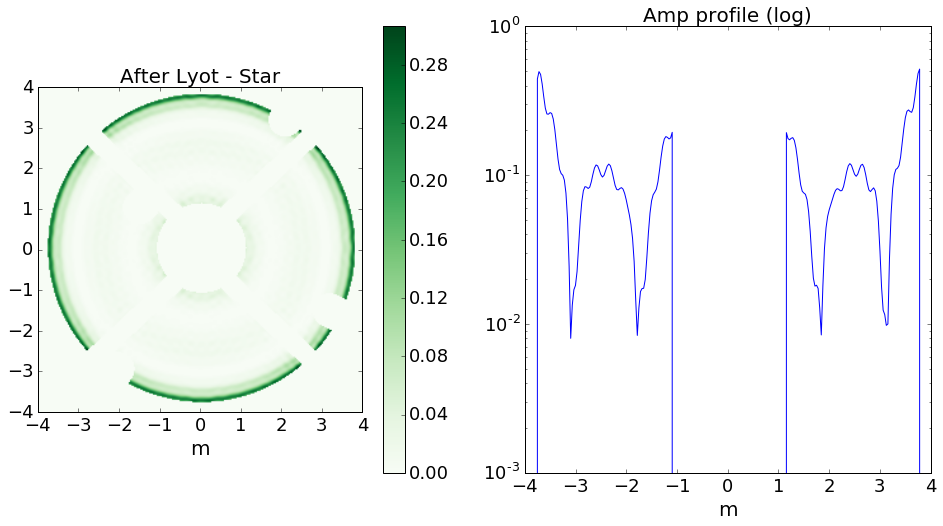

In [214]:
plt.figure(figsize=(16,8))
plt.subplot(121); plt.imshow(abs(Str_lyo_ef)**2,origin='lower',
                             extent=(px_min,px_max,py_min,py_max),cmap='Greens')
plt.xlim(-4,4); plt.ylim(-4,4); plt.title('After Lyot - Star')
plt.colorbar();  plt.xlabel('m')

plt.subplot(122); plt.plot(plin,abs(Str_lyo_ef)[int(N_pix/2),:])
plt.xlim(-4,4); plt.title('Amp profile (log)')
plt.yscale('log'); plt.xlabel('m')

Seems like non-apodized waves cannot be completely blocked out. Variation within the bandwidth should not matter (tested)

---
## Apodization

In [219]:
apo_h_d = apo_h_d_[::4,::4]

aNaxis = apo_h_h['NAXIS1']/4
a_pixs = apo_h_h['pixscale']*4

In [221]:
apo_h_p = pad_array(apo_h_d,N_pix)

In [222]:
%time
Str_ffoc_ef = Ef_aft_from_Ef(Str_inc_ef * apo_h_p)

CPU times: user 2 µs, sys: 1e+03 ns, total: 3 µs
Wall time: 6.91 µs


#### FPM

In [226]:
Str_coro_ef = Str_ffoc_ef * fpm_h_p

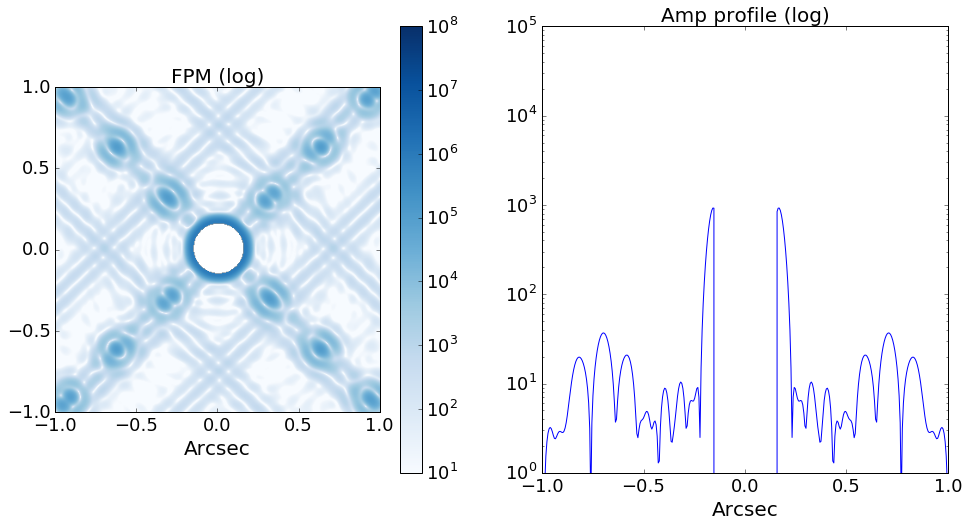

In [229]:
plt.figure(figsize=(16,8))
plt.subplot(121); plt.imshow(abs(Str_coro_ef)**2,origin='lower', \
                             extent=(kx_min,kx_max,ky_min,ky_max),norm=LogNorm(), \
                             cmap='Blues')
plt.xlim(-1,1); plt.ylim(-1,1); plt.title('FPM (log)')
plt.xlabel('Arcsec'); plt.colorbar(); plt.clim(10,1e8)

plt.subplot(122); plt.plot(klin,abs(Str_coro_ef)[int(N_pix/2),:])
plt.xlim(-1,1); plt.ylim(1,1e5); plt.title('Amp profile (log)')
plt.xlabel('Arcsec'); plt.yscale('log')

Cute satellites

#### Lyot

In [230]:
%time
Str_2pup_ef = Ef_ift_from_Ef(Str_coro_ef)

CPU times: user 2 µs, sys: 1e+03 ns, total: 3 µs
Wall time: 5.96 µs


In [231]:
Str_lyo_ef = Str_2pup_ef * lyo_h_p

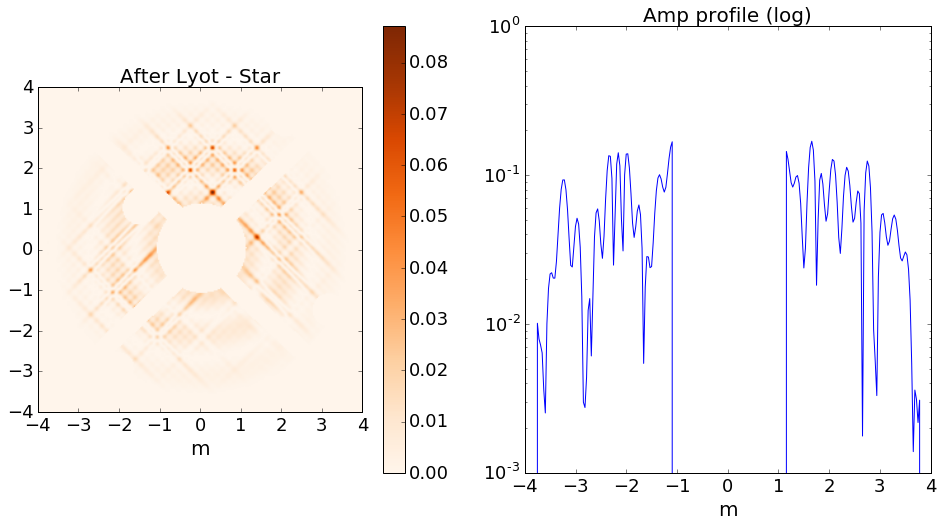

In [234]:
plt.figure(figsize=(16,8))
plt.subplot(121); plt.imshow(abs(Str_lyo_ef)**2,origin='lower',
                             extent=(px_min,px_max,py_min,py_max),cmap='Oranges')
plt.xlim(-4,4); plt.ylim(-4,4); plt.title('After Lyot - Star')
plt.colorbar();  plt.xlabel('m')

plt.subplot(122); plt.plot(plin,abs(Str_lyo_ef)[int(N_pix/2),:])
plt.xlim(-4,4); plt.title('Amp profile (log)')
plt.yscale('log'); plt.xlabel('m')

Great! I guess this is what is expected: To ensure high throughput, the Lyot stop is made somewhat larger than necessary for "traditional" flat incident light (above). Yet it is perfectly suitable for apodized input.

Apart from the uniform "grid" lines from spider/satellites and/or numerical discretization, this agrees with Soummer+[2011](http://iopscience.iop.org/article/10.1088/0004-637X/729/2/144/meta)

### Residual star light in final image plane

In [235]:
%time
Str_final_ef = Ef_aft_from_Ef(Str_lyo_ef)

CPU times: user 2 µs, sys: 1e+03 ns, total: 3 µs
Wall time: 5.96 µs


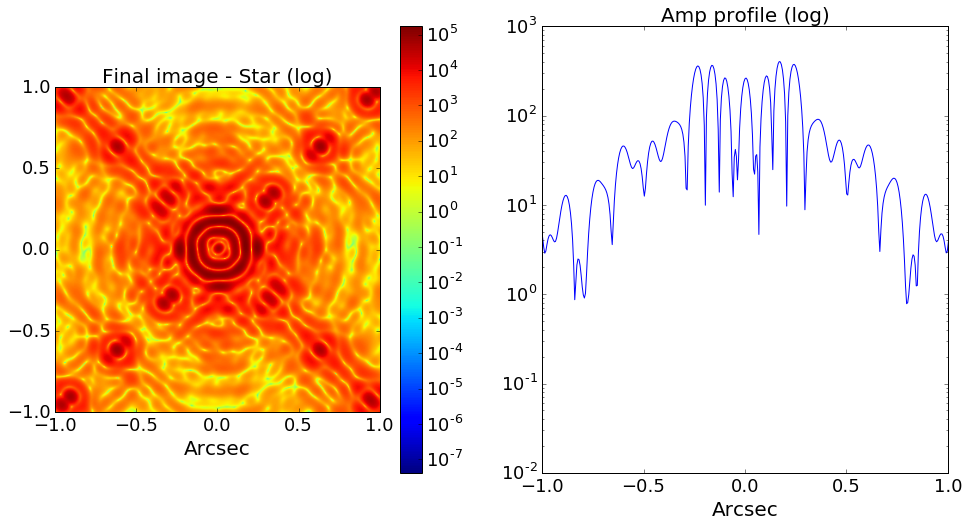

In [236]:
plt.figure(figsize=(16,8))
plt.subplot(121); plt.imshow(abs(Str_final_ef)**2,origin='lower', \
                             extent=(kx_min,kx_max,ky_min,ky_max),norm=LogNorm())
plt.xlim(-1,1); plt.ylim(-1,1); plt.title('Final image - Star (log)')
plt.xlabel('Arcsec'); plt.colorbar()

plt.subplot(122); plt.plot(klin,abs(Str_final_ef)[int(N_pix/2),:])
plt.xlim(-1,1); plt.title('Amp profile (log)')
plt.xlabel('Arcsec'); plt.yscale('log')

Good enough? We will see in the `full_opt` [notebook](https://github.com/Mipanox/GPI_stuff/blob/master/full_opt.ipynb)